In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
%cd /content

/content


In [ ]:
# io緩慢 先拷貝數據
!mkdir ./data
!cp drive/MyDrive/AI\ poster/LA.zip ./data/
%cd ./data 
!unzip LA.zip
!ls

In [ ]:
gpu_info = !nvidia-smi 
gpu_info = '\n'.join(gpu_info) 
if gpu_info.find('failed') >= 0: 
    print('Not connected to a GPU') 
else: 
    print(gpu_info)

Wed Jan 11 09:07:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

import torchaudio
import matplotlib.pyplot as plt
import requests

# 生成頻譜圖
# from scipy.io.wavfile import read as wavread # 讀取wav檔案
# from scipy.fftpack import fft  # 傅立葉轉換模組
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Device:', device)


Device: cuda


Shape of waveform: torch.Size([1, 32366])
Sample rate of waveform: 16000


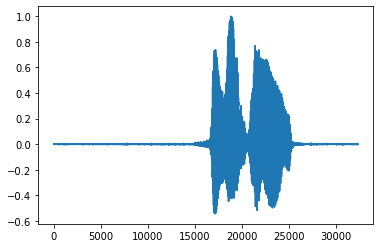

In [ ]:
# 資料前處理，先讀取第一筆進行測試
# 嘗試FLAC直接轉tensor


filename = 'LA/ASVspoof2019_LA_train/flac/LA_T_8184669.flac'
waveform, sample_rate = torchaudio.load(filename)

print('Shape of waveform: {}'.format(waveform.size()))
print('Sample rate of waveform: {}'.format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())
plt.show()

Shape of spectrogram: torch.Size([1, 196, 166])
Shape of spectrogram: torch.Size([1, 196, 166])


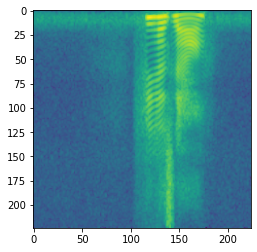

In [ ]:
# Spectrogram
specgram = torchaudio.transforms.Spectrogram(n_fft=390)(waveform)
print('Shape of spectrogram:', specgram.size())

import torchvision.transforms as T
transform = T.Compose([T.Resize((224,224))])
specgram1 = transform(specgram)

# print(specgram)
print('Shape of spectrogram:', specgram.size())
plt.figure()
plt.imshow(specgram1.log2()[0, :, :].numpy())
plt.show()

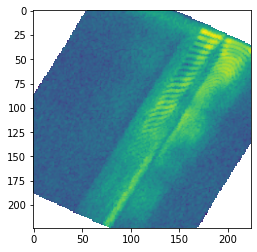

Shape of spectrogram: torch.Size([1, 224, 224])


In [ ]:

transform2 = T.Compose([T.RandomRotation((-30,30), expand=False),T.Resize((224,224))])
specgram2 = transform2(specgram)
plt.figure()
plt.imshow(specgram2.log2()[0, :, :].numpy())
plt.show()
print('Shape of spectrogram:', specgram2.size())


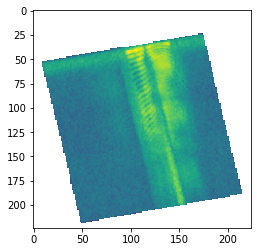

Shape of spectrogram: torch.Size([1, 224, 224])


In [ ]:
transform3 = T.Compose([T.RandomAffine(degrees=(-50,50), translate=(0, 0.1), scale=(0.7, 0.8), shear=(0,0)),T.Resize((224,224))])
specgram3 = transform3(specgram)
plt.figure()
plt.imshow(specgram3.log2()[0, :, :].numpy())
plt.show()
print('Shape of spectrogram:', specgram3.size())


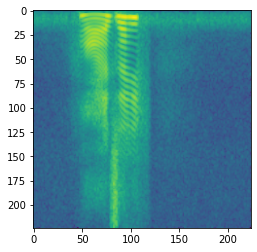

Shape of spectrogram: torch.Size([1, 224, 224])


In [ ]:
transform4 = T.Compose([T.RandomHorizontalFlip(p=1),T.Resize((224,224))])
specgram4 = transform4(specgram)
plt.figure()
plt.imshow(specgram4.log2()[0, :, :].numpy())
plt.show()
print('Shape of spectrogram:', specgram4.size())


In [ ]:
# print(next(iter(mini_train_data)).shape)

In [ ]:
# 對不符合資料夾結構資料者需自訂義Dataset->Dataloader

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import random

def label_dct_loader(path):
  # bonafide_label_dct = {}
  # spoof_label_dct = {}
  label_dct = {}
  n = 0
  with open(path,'r') as f:
    for line in f:
      line=line.split()
      if line[4] == 'bonafide':
        label_dct[line[1]]= 1
      else:
        label_dct[line[1]]= 0
  print(label_dct)
  return label_dct

# def label_maker(label_dct,data_lst):
#   label = []
#   for name in data_lst:
#     if name in label_dct:  
#       # print(name)
#       label.append(label_dct[name])
#   print(f'Label 數量: {len(label)}')
#   print("label",label)
#   return label

def flac_loader(path,label_dct,test=False):
    print(path)
    specgram_lst = []
    specgram_name = []
    label = []
    switch = 1
    bonafide = 0
    spoof = 0
    count = 0
    dir_list = os.listdir(path)
    transform = T.Compose([T.Resize((224,224))])
    
    random.seed(0)
    random.shuffle(dir_list)
    for fileName in dir_list:
      if switch: # 測試時控制數據集大小
        dataName = fileName.split('.')[0]
        if dataName in label_dct: # Label中缺少部分wav檔案
          waveform, sample_rate = torchaudio.load(path+"/"+fileName)
          specgram = torchaudio.transforms.Spectrogram(n_fft=390)(waveform)        
          if label_dct[dataName] == 1 : # bonafaid 需要增加十倍資料數量
            specgram1 = transform(specgram)
            specgram_lst.append(specgram1)
            # specgram2 = transform2(specgram)
            # specgram_lst.append(specgram2)
            # specgram3 = transform3(specgram)
            # specgram_lst.append(specgram3)
            # specgram4 = transform4(specgram)
            # specgram_lst.append(specgram4)
            # specgram5 = transform2(specgram)
            # specgram_lst.append(specgram5)
            # specgram6 = transform2(specgram)
            # specgram_lst.append(specgram6)
            # specgram7 = transform3(specgram)
            # specgram_lst.append(specgram7)
            # specgram8 = transform3(specgram)
            # specgram_lst.append(specgram8)
            for _ in range(1):
              # specgram_name.append(dataName)
              label.append(1)
              bonafide += 1
          elif spoof <= 3000: # spoof 不需要增加資料量
            specgram = transform(specgram)
            specgram_lst.append(specgram)
            # specgram_name.append(dataName)
            label.append(0)
            spoof += 1
        count +=1
        if test is True and count == 2000:
          switch = 0
    print(f'圖片數量: B:{bonafide},S: {spoof} Total: {bonafide+spoof} ')
    return specgram_lst, label


class customDataset(Dataset):
    def __init__(self, data_path, label_path, mode= "spoof"):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.label_dct = label_dct_loader(label_path)
        self.data, self.label = flac_loader(data_path,self.label_dct)
        # self.label = label_maker(self.label_dct, self.data_lst)
        print(f'Dataset data: {len(self.data)}, Dataset label:{len(self.label)}')

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        return self.data[index], self.label[index]

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.label)

In [ ]:
batch_size = 8

data_path = 'LA/ASVspoof2019_LA_train/flac'
eval_path = 'LA/ASVspoof2019_LA_eval/flac'
label_path = 'LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
eval_label_path = 'LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'


train_data_dset = customDataset(data_path, label_path)
eval_data_dset = customDataset(eval_path, eval_label_path)

train_datas = DataLoader(train_data_dset, batch_size=batch_size, shuffle=True)
eval_datas = DataLoader(eval_data_dset, batch_size=batch_size, shuffle=True)


{'LA_T_1138215': 1, 'LA_T_1271820': 1, 'LA_T_1272637': 1, 'LA_T_1276960': 1, 'LA_T_1341447': 1, 'LA_T_1363611': 1, 'LA_T_1596451': 1, 'LA_T_1608170': 1, 'LA_T_1684951': 1, 'LA_T_1699801': 1, 'LA_T_1703395': 1, 'LA_T_1736342': 1, 'LA_T_1779188': 1, 'LA_T_1786825': 1, 'LA_T_1787246': 1, 'LA_T_1905558': 1, 'LA_T_2205687': 1, 'LA_T_2220901': 1, 'LA_T_2361751': 1, 'LA_T_2373806': 1, 'LA_T_2417641': 1, 'LA_T_2520083': 1, 'LA_T_2562689': 1, 'LA_T_2564579': 1, 'LA_T_2732709': 1, 'LA_T_2759900': 1, 'LA_T_2838981': 1, 'LA_T_2873890': 1, 'LA_T_2938316': 1, 'LA_T_3131990': 1, 'LA_T_3141223': 1, 'LA_T_3167734': 1, 'LA_T_3187715': 1, 'LA_T_3215578': 1, 'LA_T_3247389': 1, 'LA_T_3346004': 1, 'LA_T_3441957': 1, 'LA_T_3561136': 1, 'LA_T_3576775': 1, 'LA_T_3580508': 1, 'LA_T_3635733': 1, 'LA_T_3636245': 1, 'LA_T_3810183': 1, 'LA_T_3849267': 1, 'LA_T_3995089': 1, 'LA_T_3999087': 1, 'LA_T_3999267': 1, 'LA_T_4053835': 1, 'LA_T_4118798': 1, 'LA_T_4155454': 1, 'LA_T_4179989': 1, 'LA_T_4197307': 1, 'LA_T_42377

In [ ]:
print(eval_data_dset[1:2])
len(eval_data_dset)

([tensor([[[2.2955e-02, 2.8206e-05, 2.6248e-05,  ..., 6.2516e-06,
          2.0105e-05, 6.7537e-04],
         [3.2327e-02, 2.0863e-03, 4.5597e-03,  ..., 3.1146e-03,
          3.4540e-03, 1.7419e-03],
         [2.5988e-02, 8.1194e-03, 2.8337e-02,  ..., 2.0032e-02,
          2.1841e-02, 3.5153e-03],
         ...,
         [3.4131e-07, 4.2340e-07, 1.6723e-07,  ..., 3.3956e-07,
          2.8516e-07, 2.1898e-07],
         [4.1498e-07, 5.8516e-07, 1.1040e-07,  ..., 2.8772e-07,
          4.4491e-07, 3.5757e-07],
         [3.0967e-07, 6.0608e-07, 5.7902e-08,  ..., 2.4777e-07,
          1.9478e-07, 7.5451e-07]]])], [0])


33209

In [ ]:
import torch.nn as nn
class CNN(nn.Module):
  def __init__(self):
      super().__init__()
      # 4 conv/ flatten / linear / softmax
      # N x 1 x 224 x 224
      self.conv1 = nn.Sequential(
          nn.Conv2d(
              in_channels=1,
              out_channels=16,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.Conv2d(
              in_channels=16,
              out_channels=16,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
      )
      # N x 16 x 112 x 112
      self.conv2 = nn.Sequential(
          nn.Conv2d(
              in_channels=16,
              out_channels=32,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(
              in_channels=32,
              out_channels=32,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
      )
      # N x 32 x 56 x 56
      self.conv3 = nn.Sequential(
          nn.Conv2d(
              in_channels=32,
              out_channels=64,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          
      # N x 64 x 28 x 28
          nn.Conv2d(
              in_channels=64,
              out_channels=64,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
      )
      # N x 64 x 14 x 14
      self.conv4 = nn.Sequential(
          nn.Conv2d(
              in_channels=64,
              out_channels=128,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
      # N x 128 x 7 x 7
          nn.Conv2d(
              in_channels=128,
              out_channels=128,
              kernel_size=3,
              stride=1,
              padding=1
          ),
          nn.BatchNorm2d(128),
          nn.ReLU(),
      )
      # N x 128 x 7 x 7
      self.flatten = nn.Flatten()
      self.linear = nn.Linear(6272, 2)
      # self.softmax = nn.Softmax(dim=1)

  def forward(self, input_data):
    x = self.conv1(input_data)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.flatten(x)
    predictions = self.linear(x)
    # predictions = self.softmax(logits)
    return predictions

In [ ]:
import torch.optim as optim
model = CNN()
model.to(device)

from torchsummary import summary
summary(model, (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]           2,320
       BatchNorm2d-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
         MaxPool2d-7         [-1, 16, 112, 112]               0
            Conv2d-8         [-1, 32, 112, 112]           4,640
       BatchNorm2d-9         [-1, 32, 112, 112]              64
             ReLU-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 32, 112, 112]           9,248
      BatchNorm2d-12         [-1, 32, 112, 112]              64
             ReLU-13         [-1, 32, 112, 112]               0
        MaxPool2d-14           [-1, 32,

In [ ]:
def evaluate(model, total_vals):
  model.eval()
  with torch.no_grad():
    total_acc = 0
    for mini_x, mini_y in total_vals:
      mini_x = mini_x.to(device)
      # print(mini_x)
      mini_y = mini_y.to(device)
      # print(mini_y, end = '--')
      scores = model(mini_x)
      # print("scores",scores)
      predictions = scores.max(1)[1]
      # print("predictions",predictions)
      acc = predictions.eq(mini_y).sum().item()
      total_acc += acc
      # print("total_acc",total_acc)
    # print(total_acc,len(eval_data_dset))
    print("Acc", total_acc/len(eval_data_dset))  # why total eval_number

In [ ]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 20
PRINT_EVERY = 40
for epoch in range(NUM_EPOCHS):
  sum_loss = 0
  for counter, (mini_train_x,mini_train_y) in enumerate(train_datas):
    mini_train_x, mini_train_y = mini_train_x.to(device), mini_train_y.to(device)
    prediction = model(mini_train_x)
    loss_function = nn.CrossEntropyLoss()
    loss = loss_function(prediction, mini_train_y)
    if counter % PRINT_EVERY == 0 and counter !=0:
      # print(f'EPOCH: {epoch +1}: {sum_loss/counter}', end = '/')
      print(f'EPOCH: {epoch +1}: {sum_loss/counter}')
      sum_loss = 0
      # evaluate(model,eval_datas)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    sum_loss += loss.item()
  evaluate(model,eval_datas)

EPOCH: 1: 1.3231970630586147
EPOCH: 1: 0.43004683312028646
EPOCH: 1: 0.32754425033926965
EPOCH: 1: 0.22276961524039507
EPOCH: 1: 0.16028311476111412
EPOCH: 1: 0.12951214127242566
EPOCH: 1: 0.11686074488929339
EPOCH: 1: 0.10101172649301589
EPOCH: 1: 0.08504545378188293
EPOCH: 1: 0.07724072147160768
EPOCH: 1: 0.07842128385197032
EPOCH: 1: 0.07512511145323515
EPOCH: 1: 0.059407493013602035
EPOCH: 1: 0.049726900405117444
EPOCH: 1: 0.04847735139230887
EPOCH: 1: 0.051900056158774535
EPOCH: 1: 0.0463653749841101
Acc 0.6145787221484432
EPOCH: 2: 0.8807509243488312
EPOCH: 2: 0.31347818300127983
EPOCH: 2: 0.1946086826423804
EPOCH: 2: 0.1663476420333609
EPOCH: 2: 0.18021062998101114
EPOCH: 2: 0.11769553277020653
EPOCH: 2: 0.07879176488412278
EPOCH: 2: 0.08856333464354975
EPOCH: 2: 0.05849146197950985
EPOCH: 2: 0.06848791787400842
EPOCH: 2: 0.05618772730231285
EPOCH: 2: 0.054212199593894186
EPOCH: 2: 0.04125005029625474
EPOCH: 2: 0.038411362462544014
EPOCH: 2: 0.04006346438700954
EPOCH: 2: 0.03741

In [ ]:
# Save the model

print(os.getcwd())
class_name = model.__class__.__name__
print(f'Save model in dir {"./model_theo/"+"3000"+class_name}')
# torch.save(model, "./1CNN")
torch.save(model, "../drive/MyDrive/AI poster/LA/model_theo/"+"3000"+class_name)

/content/data
Save model in dir ./model_theo/3000CNN
